In [ ]:
import pandas as pd
import numpy as np
import torch
import sys
import warnings
import os

from datetime import datetime

from common.visualize import plot_predictions
from common.logger import Logger
from config.config import DATE_COL_NM, TARGET_COL_NM, NLINEAR_PARAMETER
from data.data_loader import load_data, create_windows_for_inference
from data.data_factor import create_dataloaders
from model.nlinear.execute_module import NLinearModel
from model.dlinear.execute_module import DLinearModel, DNLinearModel
from model.cnn_nlinear.execute_module import CNN_NLinear
from model.hybrid.execute_module import HybridModel
from utils.tools import generate_predictions
from utils.metrics import MSE, MAE, MAPE

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:.4f}".format
pd.options.display.min_rows = 10
pd.options.display.max_rows = 100
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 30


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
## Log 선언
CREATED_TIME = datetime.now()
LOG_PATH = "./logs/"
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
LOGFILE_NM = "ltsf_linear_inference_log"

## Define Logger
logger = Logger(path=LOG_PATH, name=LOGFILE_NM, date=CREATED_TIME).logger

logger.info("NLinear, DLinear, NDLinear, CNN_NLiear, Stacking(Hybrid) model inference is Start")

[11/29/24 21:25:53] INFO     2024-11-29 21:25:53,621 <module> Line 11 [INFO]: NLinear, DLinear,    ]8;id=717105;file:///var/folders/rm/xhhz_cp93r3dzybd5hyvfr_w0000gn/T/ipykernel_13032/2165646596.py\2165646596.py]8;;\:]8;id=300538;file:///var/folders/rm/xhhz_cp93r3dzybd5hyvfr_w0000gn/T/ipykernel_13032/2165646596.py#11\11]8;;\
                             NDLinear, CNN_NLiear, Stacking(Hybrid) model inference is Start                       

# Load Data

In [4]:
# Set torch
device = torch.device("cpu")

In [5]:
raw_data = load_data("./dataset/ETTh1.csv", date_col_nm=DATE_COL_NM, target_col_nm=TARGET_COL_NM)

logger.info(f"Total data count: {raw_data.shape[0]}")
logger.info(f"Date: {raw_data.index.min()} ~ {raw_data.index.max()}")

Load dataset(cnt: 17420)


                    INFO     2024-11-29 21:25:53,647 <module> Line 3 [INFO]: Total data count:      ]8;id=5984;file:///var/folders/rm/xhhz_cp93r3dzybd5hyvfr_w0000gn/T/ipykernel_13032/1801551508.py\1801551508.py]8;;\:]8;id=499822;file:///var/folders/rm/xhhz_cp93r3dzybd5hyvfr_w0000gn/T/ipykernel_13032/1801551508.py#3\3]8;;\
                             17420                                                                                 

                    INFO     2024-11-29 21:25:53,649 <module> Line 4 [INFO]: Date: 2016-07-01       ]8;id=677650;file:///var/folders/rm/xhhz_cp93r3dzybd5hyvfr_w0000gn/T/ipykernel_13032/1801551508.py\1801551508.py]8;;\:]8;id=53471;file:///var/folders/rm/xhhz_cp93r3dzybd5hyvfr_w0000gn/T/ipykernel_13032/1801551508.py#4\4]8;;\
                             00:00:00 ~ 2018-06-26 19:00:00                                                        

In [6]:
(
    (train_set, train_loader),
    (val_set, val_loader),
    (test_set, test_loader),
    (pred_set, pred_loader)
) =  create_dataloaders(
    embed = 'timeF', 
    train_only = False,
    batch_size = NLINEAR_PARAMETER['batch_size'],
    freq = 'h',
    data_type_list = ['train', 'val', 'test', 'pred'],
    seq_len = NLINEAR_PARAMETER['window_size'],
    label_len = NLINEAR_PARAMETER['forecast_size'],
    pred_len = NLINEAR_PARAMETER['forecast_size'],
    features = 'S',
    target = 'OT',
    root_path = './dataset',
    data_path = 'ETTh1.csv',
)

# Load Models

In [7]:
nlinear_model = NLinearModel(
    window_size=336,
    forecast_size=96,
    individual=False,
    feature_size=1,
    logger=logger,
)
nlinear_model.load_state_dict(torch.load('./result/best_model__nlinear.pth'))

dlinear_model = DLinearModel(
    window_size=336,
    forecast_size=96,
    individual=False,
    enc_in=1,
    logger=logger,
)
dlinear_model.load_state_dict(torch.load('./result/best_model__dlinear.pth'))

dnlinear_model = DNLinearModel(
    window_size=336,
    forecast_size=96,
    individual=False,
    enc_in=1,
    kernel_size=25,
    logger=logger,
)
dnlinear_model.load_state_dict(torch.load('./result/best_model__dnlinear.pth'))

cnn_nlinear_model = CNN_NLinear(
    window_size=336,
    forecast_size=96,
    conv_kernel_size=44,
    conv_filters=28,
    in_channels=1,
    dropout_rate=0.3,
    logger=logger,
)
cnn_nlinear_model.load_state_dict(torch.load('./result/best_model__cnn_nlinear.pth'))

hybrid_model = HybridModel(
    models=[nlinear_model, dlinear_model, dnlinear_model, cnn_nlinear_model],
    window_size=336,
    dropout_rate=0.3,
    logger=logger,
)
hybrid_model.load_state_dict(torch.load('./result/best_model__hybrid.pth'))

<All keys matched successfully>

# Inference

## Test set 예측

In [8]:
nlinear_pred_result = nlinear_model.final_predict(test_set, test_loader, device, logger)
dlinear_pred_result = dlinear_model.final_predict(test_set, test_loader, device, logger)
dnlinear_pred_result = dnlinear_model.final_predict(test_set, test_loader, device, logger)
cnn_nlinear_pred_result = cnn_nlinear_model.final_predict(test_set, test_loader, device, logger)
hybrid_pred_result = hybrid_model.final_predict(test_set, test_loader, device, logger)

                    INFO     2024-11-29 21:25:53,742 final_predict Line 203 [INFO]: [NLinear  execute_module.py:203
                             Score] MSE: 0.0546, MAE: 0.1797, MAPE: 0.1443                                         

                    INFO     2024-11-29 21:25:53,824 final_predict Line 248 [INFO]: [DLinear  execute_module.py:248
                             Score] MSE: 0.0542, MAE:0.1775, MAPE: 0.1415                                          

                    INFO     2024-11-29 21:25:53,906 final_predict Line 494 [INFO]: [DNLinear execute_module.py:494
                             Score] MSE: 0.0527, MAE: 0.1763, MAPE: 0.1420                                         

[11/29/24 21:25:54] INFO     2024-11-29 21:25:54,070 final_predict Line 265 [INFO]: [CNN +    execute_module.py:265
                             NLinear Score] MSE: 0.0547, MAE: 0.1823, MAPE: 0.1485                                 

                    INFO     2024-11-29 21:25:54,734 final_predict Line 224 [INFO]: [Hybrid   execute_module.py:224
                             model Score] MSE: 0.0537, MAE: 0.1783, MAPE: 0.1436                                   

## Test set 예측오차

In [41]:
testset_metric = pd.DataFrame(
    {
        'MODEL_NAME': ['NLinear', 'DLinear', 'DNLinear', 'CNN_NLinear', 'Hybrid'],
        'MSE': [
            MSE(nlinear_pred_result['pred'], nlinear_pred_result['true']),
            MSE(dlinear_pred_result['pred'], dlinear_pred_result['true']),
            MSE(dnlinear_pred_result['pred'], dnlinear_pred_result['true']),
            MSE(cnn_nlinear_pred_result['pred'], cnn_nlinear_pred_result['true']),
            MSE(hybrid_pred_result['pred'], hybrid_pred_result['true']),
        ],
        'MAE': [
            MAE(nlinear_pred_result['pred'], nlinear_pred_result['true']),
            MAE(dlinear_pred_result['pred'], dlinear_pred_result['true']),
            MAE(dnlinear_pred_result['pred'], dnlinear_pred_result['true']),
            MAE(cnn_nlinear_pred_result['pred'], cnn_nlinear_pred_result['true']),
            MAE(hybrid_pred_result['pred'], hybrid_pred_result['true']),
        ],
        'MAPE': [
            MAPE(nlinear_pred_result['pred'], nlinear_pred_result['true']),
            MAPE(dlinear_pred_result['pred'], dlinear_pred_result['true']),
            MAPE(dnlinear_pred_result['pred'], dnlinear_pred_result['true']),
            MAPE(cnn_nlinear_pred_result['pred'], cnn_nlinear_pred_result['true']),
            MAPE(hybrid_pred_result['pred'], hybrid_pred_result['true']),
        ]
    }
)

display(testset_metric)

,MODEL_NAME,MSE,MAE,MAPE
0,NLinear,0.0546,0.1797,0.1443
1,DLinear,0.0542,0.1775,0.1415
2,DNLinear,0.0527,0.1763,0.1420
3,CNN_NLinear,0.0547,0.1823,0.1485
4,Hybrid,0.0537,0.1783,0.1436


## 시각화

### 추론을 위한 Dataset 생성

In [9]:
# 윈도우 생성
date_list, x_list, y_list = create_windows_for_inference(raw_data, scaler = train_set.scaler)

In [10]:
nliear_pred_list = generate_predictions(nlinear_model, x_list)
dlinear_pred_list = generate_predictions(dlinear_model, x_list)
dnlinear_pred_list = generate_predictions(dnlinear_model, x_list)
cnn_nlinear_pred_list = generate_predictions(cnn_nlinear_model, x_list)
hybrid_pred_list = generate_predictions(hybrid_model, x_list)

## 모델별 Prediction 결과
model_pred_dict = {
    "NLinear": nliear_pred_list,
    "DLinear": dlinear_pred_list,
    "DNLinear": dnlinear_pred_list,
    "CNN_NLinear": cnn_nlinear_pred_list,
    "Hybrid": hybrid_pred_list,
}

### Plot

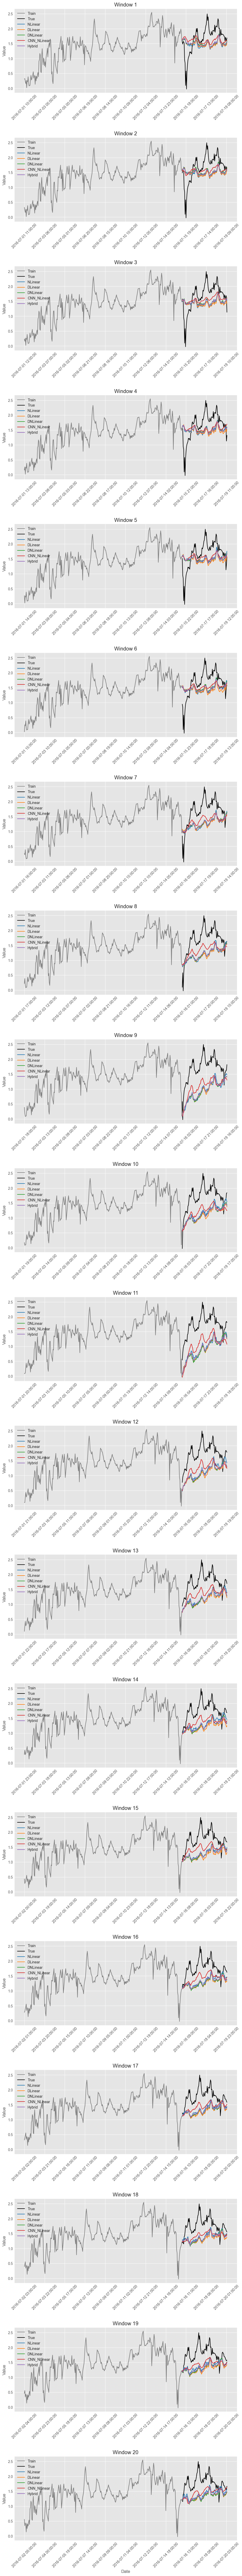

In [51]:
## 모델별 Prediction 결과
model_pred_dict = {
    "NLinear": nliear_pred_list[10:30],
    "DLinear": dlinear_pred_list[10:30],
    "DNLinear": dnlinear_pred_list[10:30],
    "CNN_NLinear": cnn_nlinear_pred_list[10:30],
    "Hybrid": hybrid_pred_list[10:30],
}

plot_predictions(date_list[10:30], x_list[10:30], y_list[10:30], model_pred_dict)

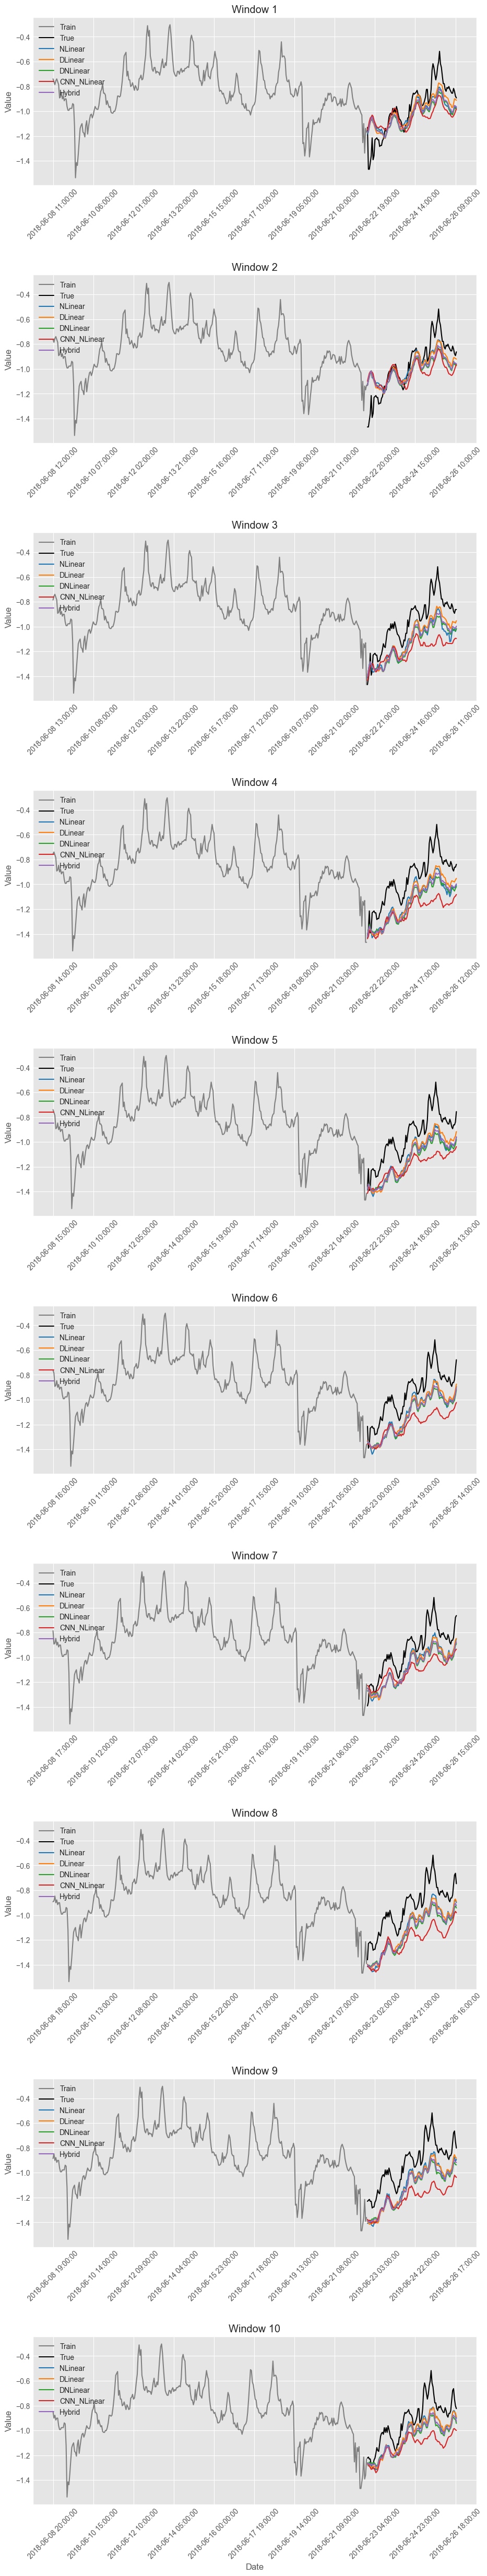

In [47]:
## 모델별 Prediction 결과
model_pred_dict = {
    "NLinear": nliear_pred_list[-10:],
    "DLinear": dlinear_pred_list[-10:],
    "DNLinear": dnlinear_pred_list[-10:],
    "CNN_NLinear": cnn_nlinear_pred_list[-10:],
    "Hybrid": hybrid_pred_list[-10:],
}

plot_predictions(date_list[-10:], x_list[-10:], y_list[-10:], model_pred_dict)

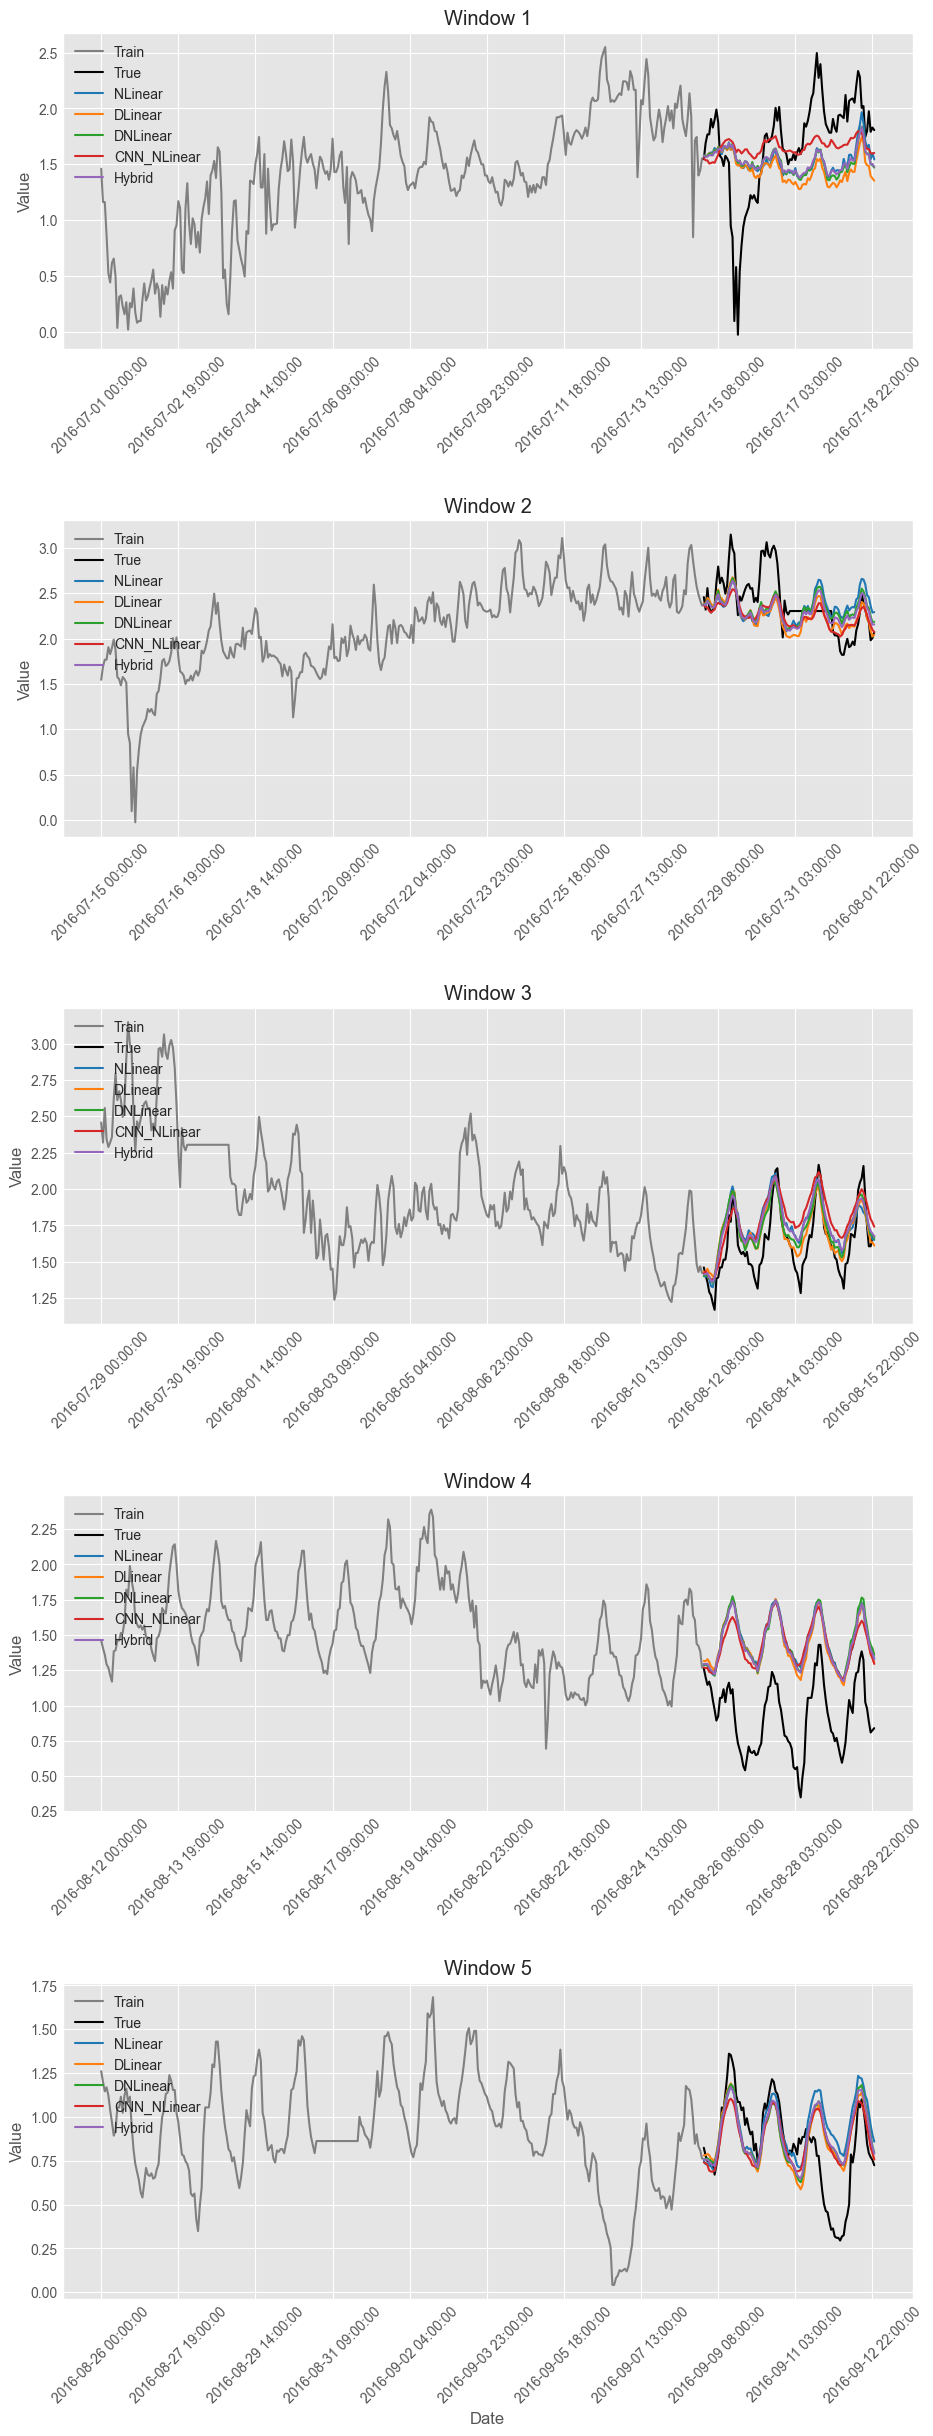

In [48]:
index_list = [0, 336, 672, 1008, 1344]

## 모델별 Prediction 결과
model_pred_dict = {
    "NLinear": [nliear_pred_list[i] for i in index_list],
    "DLinear": [dlinear_pred_list[i] for i in index_list],
    "DNLinear": [dnlinear_pred_list[i] for i in index_list],
    "CNN_NLinear": [cnn_nlinear_pred_list[i] for i in index_list],
    "Hybrid": [hybrid_pred_list[i] for i in index_list],
}

plot_predictions(
    [date_list[i] for i in index_list],
    [x_list[i] for i in index_list],
    [y_list[i] for i in index_list],
    model_pred_dict
)